#### NSBL: Two parameter case, sum of two gaussian kernels, multimodal evidence
##### - compare jacobian and hessian calculation using finite difference approximation
##### - plot objective function, log-evidence, and jacobian for varying logalpha1 and logalpha2

In [1]:
#!/usr/bin/python
import numpy as np
import numpy.linalg as la
import scipy.stats as st
import scipy.optimize as sopt
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, math, sys
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
np.random.seed(88)
#os.system('rm *.pdf *.eps *.png');

In [2]:
K = 2 # number of kernels
Nphi = 2 # dimension of parameter space
aCoeff  = np.ones((1,K)) 
muVec  = np.zeros((Nphi,K))
SigMat = np.zeros((Nphi,Nphi,K))
rCoeff = 1e-04*np.ones((1,Nphi)) 
sCoeff = 1e-04*np.ones((1,Nphi))

In [3]:
muVec[0,0] = 1.0
muVec[1,1] = 1.0
rho = -0.9
var = 0.05
fac = 0.25
SigMat[:,:,0] = [[var,var*rho],[var*rho,var]]
SigMat[:,:,1] = [[fac*var,fac*var*rho],[fac*var*rho,fac*var]]

In [4]:
def NSBL(logalpIN):
    alp = np.exp(logalpIN)
    A = np.diag(alp)
    Ainv = np.diag(1/alp)
    Bmat = np.zeros((Nphi,Nphi,K))
    Pmat = np.zeros((Nphi,Nphi,K))
    mVec = np.zeros((Nphi,K))
    wVec = np.zeros((1,K))
    vVec = np.zeros((Nphi,K))
    vbarVec = np.zeros((Nphi,1))
    jVec = np.zeros((Nphi,1))
    Hmat = np.zeros((Nphi,Nphi))
    for k in range(0,K):
        Bmat[:,:,k] = SigMat[:,:,k] + Ainv
        Pmat[:,:,k] = Ainv - Ainv@la.inv(Bmat[:,:,k])@Ainv
        mVec[:,k]   = Pmat[:,:,k]@la.inv(SigMat[:,:,k])@muVec[:,k]
        wVec[0,k]   = aCoeff[0,k]*st.multivariate_normal.pdf(muVec[:,k],[0]*Nphi,Bmat[:,:,k])
        for ii in range(0,Nphi):
            vVec[ii,k] = 0.5*(1.0 - alp[ii]*(Pmat[ii,ii,k] + mVec[ii,k]**2))
    evid = np.sum(wVec)
    wVec = wVec/evid
    objFun = np.log(evid) + np.dot(rCoeff[0,:],logalpIN) - np.dot(sCoeff[0,:],alp)
    for ii in range(0,Nphi):
        vbarVec[ii,0] = np.dot(wVec[0,:],vVec[ii,:])
        jVec[ii,0]   = vbarVec[ii,0] + rCoeff[0,ii] - sCoeff[0,ii]*alp[ii]
        for jj in range(0,ii):
            Hmat[ii,jj] = Hmat[jj,ii]
        for jj in range(ii,Nphi):
            tmpij = 1.0 if ii==jj else 0.0
            for k in range(0,K):
                Hmat[ii,jj] = Hmat[ii,jj] + wVec[0,k]*(alp[ii]*alp[jj]*(0.5*Pmat[ii,jj,k]**2 \
                                    + mVec[ii,k]*mVec[jj,k]*Pmat[ii,jj,k]) \
                                    + vVec[jj,k]*(vVec[ii,k] - vbarVec[ii,0]))
            Hmat[ii,jj] = Hmat[ii,jj] + tmpij*(vbarVec[ii,0] - sCoeff[0,ii]*alp[ii] - 0.5)
    return np.log(evid), objFun, jVec[:,0], Hmat

In [5]:
Ngrd  = 100
LogEvidgrd  = np.zeros((Ngrd,Ngrd))
ObjFungrd   = np.zeros((Ngrd,Ngrd))
JacVecgrd   = np.zeros((Ngrd,Ngrd,Nphi))
LogAlp1bnd = [-5,10]
LogAlp2bnd = [-5,10]
LogAlp1rng = np.linspace(LogAlp1bnd[0],LogAlp1bnd[1],Ngrd)
LogAlp2rng  = np.linspace(LogAlp2bnd[0],LogAlp2bnd[1],Ngrd)
LogAlp1grd,LogAlp2grd = np.meshgrid(LogAlp1rng,LogAlp2rng)
for i in range(0,Ngrd):
    for j in range(0, Ngrd):
        LogAlpCur = np.array([LogAlp1grd[i,j],LogAlp2grd[i,j]])
        LogEvidgrd[i,j], ObjFungrd[i,j], JacVecgrd[i,j,:], _ = NSBL(LogAlpCur)

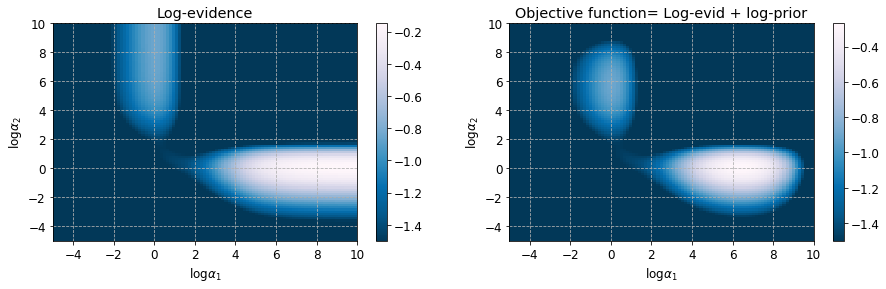

In [6]:
mpl.rcParams.update({'font.size':12})
minVal = -1.5
fig=plt.figure(1,figsize=(15,4))
plt.subplot(1, 2, 1)
plt.pcolor(LogAlp1grd,LogAlp2grd,LogEvidgrd,cmap='PuBu_r',vmin=minVal)
plt.colorbar()
plt.grid('on',linestyle='--')
plt.xlabel(r'$\log\alpha_1$')
plt.ylabel(r'$\log\alpha_2$')
plt.title('Log-evidence')

plt.subplot(1, 2, 2)
minVal = -1.5
plt.pcolor(LogAlp1grd,LogAlp2grd,ObjFungrd,cmap='PuBu_r',vmin=minVal)
plt.colorbar()
plt.grid('on',linestyle='--')
plt.xlabel(r'$\log\alpha_1$')
plt.ylabel(r'$\log\alpha_2$')
plt.title('Objective function= Log-evid + log-prior')
plt.savefig('plot_evid.eps',bbox_inches='tight')

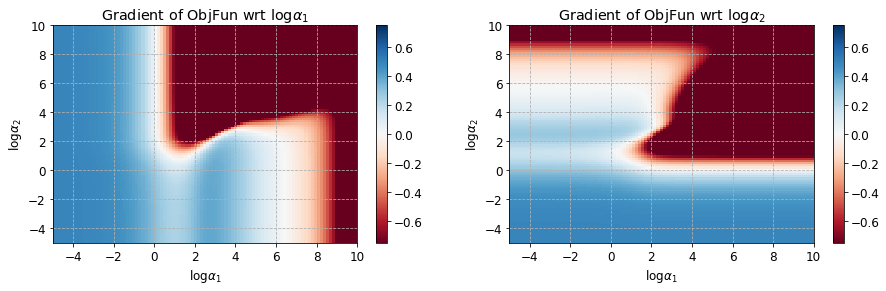

In [7]:
mpl.rcParams.update({'font.size':12})
minVal =-0.75
maxVal =0.75
fig=plt.figure(1,figsize=(15,4))
plt.subplot(1, 2, 1)
plt.pcolor(LogAlp1grd,LogAlp2grd,JacVecgrd[:,:,0],cmap='RdBu',vmin=minVal,vmax=maxVal)
#plt.pcolor(LogAlp1grd,LogAlp2grd,JacVecgrd[:,:,0],cmap='PuBu_r')
plt.colorbar()
plt.grid('on',linestyle='--')
plt.xlabel(r'$\log\alpha_1$')
plt.ylabel(r'$\log\alpha_2$')
plt.title(r'Gradient of ObjFun wrt $\log\alpha_1$')

plt.subplot(1, 2, 2)
plt.pcolor(LogAlp1grd,LogAlp2grd,JacVecgrd[:,:,1],cmap='RdBu',vmin=minVal,vmax=maxVal)
#plt.pcolor(LogAlp1grd,LogAlp2grd,JacVecgrd[:,:,1],cmap='PuBu_r')
plt.colorbar()
plt.grid('on',linestyle='--')
plt.xlabel(r'$\log\alpha_1$')
plt.ylabel(r'$\log\alpha_2$')
plt.title(r'Gradient of ObjFun wrt $\log\alpha_2$')
plt.savefig('plot_jac.eps',bbox_inches='tight')

In [8]:
def myFun(xin):
    _, Otmp, _, _ = NSBL(xin)
    return -Otmp
myi = 60
myj = 66
LogAlpCur = np.array([LogAlp1grd[myi,myj],LogAlp2grd[myi,myj]])
_, _, Jtrue, Htrue = NSBL(LogAlpCur)
Jfd = sopt.approx_fprime(LogAlpCur,myFun,1e-04)
print('Alpha value: ',LogAlpCur)
print('Jacobian (true, est):\n',Jtrue.T,'\n',Jfd)

Alpha value:  [5.         4.09090909]
Jacobian (true, est):
 [-4.50810111 -6.06419846] 
 [4.50797023 6.06382803]


In [9]:
def hessian ( x0, epsilon=1e-4):
    f1 = sopt.approx_fprime( x0, myFun, epsilon)   
    n = x0.shape[0]
    hessian = np.zeros ( ( n, n ) )
    xx = x0
    for j in range( n ):
        xx0 = xx[j] # Store old value
        xx[j] = xx0 + epsilon # Perturb with finite difference
        f2 = sopt.approx_fprime( xx, myFun, epsilon) 
        hessian[:, j] = (f2 - f1)/epsilon # scale...
        xx[j] = xx0 # Restore initial value of x0        
    return hessian
Hfd = hessian(LogAlpCur)
print('Hessian (true, est):\n',Htrue,'\n',Hfd)
w,v = la.eigh(Htrue)
print('Eigenvalues of Hessian matrix:', w)

Hessian (true, est):
 [[ 2.61773911 -4.93654466]
 [-4.93654466  7.41055033]] 
 [[-2.61780357  4.93581069]
 [ 4.93581069 -7.40485468]]
Eigenvalues of Hessian matrix: [-0.47331672 10.50160615]


In [10]:
# %matplotlib qt
# sminVal = -5.5
# smaxVal = -0.5
# fig = plt.figure(2)
# ax = fig.gca(projection='3d')
# surf = ax.plot_surface(LogAlp1grd,LogAlp2grd,ObjFungrd, cmap='PuBu_r',linewidth=0, antialiased=False,vmin=sminVal, vmax=smaxVal)
# ax.set_zlim(sminVal,smaxVal)
# ax.set_xlabel('alpha1')
# ax.set_ylabel('alpha2')
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# fig.colorbar(surf)